In [69]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mail-test/MAIL_test.csv
/kaggle/input/infor-mail/MAIL.csv


In [44]:
df = pd.read_csv('/kaggle/input/infor-mail/MAIL.csv',header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,0,-1.0,-1.00,-1.000000,-1.0,-1.00000,-1.000000,-1.0,-1.0,-1.000000,...,-1.0,-1.0,-0.148221,-1.000000,-1.000000,-1.000000,-0.754045,-1.000000,-0.718446,-1.0
1,0,-1.0,-1.00,-1.000000,-1.0,-0.82691,-0.632182,-1.0,-1.0,-0.720307,...,-1.0,-1.0,-0.554151,-1.000000,-0.936759,-0.640316,-1.000000,-0.312254,-1.000000,-1.0
2,0,-1.0,-0.84,-0.820690,-1.0,-1.00000,-1.000000,-1.0,-1.0,-0.635001,...,-1.0,-1.0,-0.608332,-0.916667,-1.000000,-0.763021,-1.000000,-1.000000,-1.000000,-1.0
3,0,-1.0,-1.00,-0.886152,-1.0,-1.00000,-0.796825,-1.0,-1.0,-1.000000,...,-1.0,-1.0,-0.387624,-1.000000,-0.895765,-0.703583,-1.000000,-0.811075,-0.716612,-1.0
4,0,-1.0,-1.00,-0.774452,-1.0,-1.00000,-0.798742,-1.0,-1.0,-1.000000,...,-1.0,-1.0,-1.000000,-0.894040,-0.894040,-1.000000,-0.496689,-1.000000,-1.000000,-1.0


In [45]:
df.shape

(3587, 401)

In [46]:
df.values[df.isnull().sum(axis=1) >= 1]

array([], shape=(0, 401), dtype=float64)

In [47]:
pel_class = np.unique(df[0])
pel_class

array([0, 1])

In [48]:
pel_value = [sum(df[0]==pel_class[0]),
             sum(df[0]==pel_class[1])]
pel_value

[1204, 2383]

In [49]:
y = df[0].values
X = df.drop([0],axis = 1).values

In [50]:
X = np.array(X)
y = np.array(y)

In [51]:
allclass = np.unique(y)
allclassnumber = [sum(y==eachclass) for eachclass in allclass]
allclassnumber

[1204, 2383]

In [52]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=1)
X_res, y_res = sm.fit_resample(X, y)

allclass = np.unique(y_res)
allclassnumber = [sum(y_res==eachclass) for eachclass in allclass]
allclassnumber

[2383, 2383]

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=1)

In [54]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [55]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
X_train_norm =  scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

In [56]:
from sklearn.decomposition import PCA
fr = PCA(n_components=400)
fr.fit(X_train_norm)
X_train_norm = fr.transform(X_train_norm)
X_test_norm = fr.transform(X_test_norm)
X_val_norm = fr.transform(X_val_norm)

In [57]:
import tensorflow as tf

In [58]:
tf.compat.v1.reset_default_graph() # Clear Model
np.random.seed(1) # Fix Randomness
tf.compat.v1.random.set_random_seed(1) # Fix Randomness
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(16, activation='relu', input_shape=(400,)), #input_shape เปลี่ยนตาม feature ของเรา
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(2, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                6416      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 6,601
Trainable params: 6,601
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
train_acc = list()
val_acc = list()
for i in range(0,400): #จะอ่านข้อมูลครั้งละเท่าไหร่  
  history = model.fit(X_train_norm, y_train, epochs= 1, batch_size = 200, validation_data= (X_val_norm, y_val))
  tmp_avg = np.mean(history.history['accuracy'])
  tmp_avg_val = np.mean(history.history['val_accuracy'])
  train_acc.append(tmp_avg)
  val_acc.append(tmp_avg_val)

16/16 [==============================] - 0s 4ms/step - loss: 0.0837 - accuracy: 0.9784 - val_loss: 0.8244 - val_accuracy: 0.7903


16/16 [==============================] - 0s 4ms/step - loss: 0.0119 - accuracy: 0.9895 - val_loss: 1.4001 - val_accuracy: 0.7969


16/16 [==============================] - 0s 5ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.7316 - val_accuracy: 0.8047


16/16 [==============================] - 0s 4ms/step - loss: 7.2609e-04 - accuracy: 1.0000 - val_loss: 1.9505 - val_accuracy: 0.8034


16/16 [==============================] - 0s 4ms/step - loss: 3.0789e-04 - accuracy: 1.0000 - val_loss: 2.1098 - val_accuracy: 0.8073


16/16 [==============================] - 0s 4ms/step - loss: 1.4873e-04 - accuracy: 1.0000 - val_loss: 2.2460 - val_accuracy: 0.8073


16/16 [==============================] - 0s 4ms/step - loss: 1.1152e-04 - accuracy: 1.0000 - val_loss: 2.2944 - val_accuracy: 0.8100


In [61]:
history.history

{'loss': [0.00011152188380947337],
 'accuracy': [1.0],
 'val_loss': [2.294407844543457],
 'val_accuracy': [0.809960663318634]}

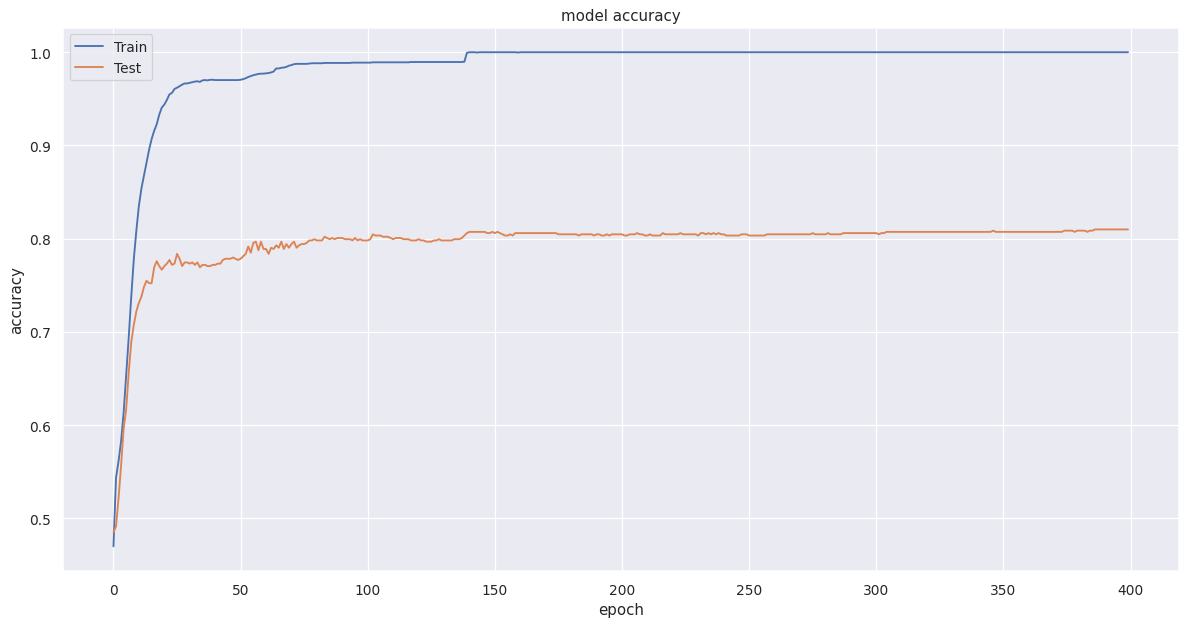

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(num=None, figsize=(16, 8), dpi=90, facecolor='w', edgecolor='k')
plt.plot()
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [63]:
y_predict = np.round(model.predict(X_test_norm))
y_predict = [i[0] for i in y_predict.tolist()]
sum(y_predict == y_test)/len(y_test)

0.8060796645702306

# test

In [70]:
df_test = pd.read_csv('/kaggle/input/mail-test/MAIL_test.csv',header = None)
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,0,-1.0,-1.000000,-0.792705,-1.000000,-1.000000,-1.000000,-0.421965,-1.00000,-1.000000,...,-1.0,-1.0,-0.088486,-1.000000,-0.903030,-1.000000,-1.000000,-1.000000,-1.000000,-1.0
1,0,-1.0,-0.941068,-0.735823,-0.791284,-0.833604,-0.882136,-1.000000,-0.73849,-0.865562,...,-1.0,-1.0,-0.859439,-0.970093,-0.970093,-0.574766,-0.715888,-0.891589,-0.837383,-1.0
2,0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,...,-1.0,-1.0,-0.703353,-1.000000,-0.936884,-0.461539,-0.850098,-0.771204,-1.000000,-1.0
3,0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,...,-1.0,-1.0,-0.729497,-0.884892,-0.769784,-1.000000,-0.453238,-0.582735,-1.000000,-1.0
4,0,-1.0,-1.000000,-0.728317,-1.000000,-0.315508,-0.515152,-1.000000,-1.00000,-1.000000,...,-1.0,-1.0,-0.090325,-1.000000,-0.741936,-1.000000,0.225804,-1.000000,-1.000000,-1.0


In [71]:
yt = df_test[0].values
Xt = df_test.drop([0],axis = 1).values

In [72]:
X_test = scaler.transform(Xt)
X_test_n = fr.transform(X_test)

In [73]:
y_predict = clf.predict(X_test_n)
print("Test accuracy : "+str(sum(yt == y_predict)/len(yt)*100))

Test accuracy : 72.25788445436785
